<a href="https://colab.research.google.com/github/Dharmendra1308/CSE-Department-Portal/blob/main/Premium_Imbalance_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from glob import glob
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set path

base_path = '/content/drive/MyDrive/Dataset/ISIC_2019'

train_image_path = os.path.join(base_path, 'ISIC_2019_Training_Input')
# test_image_path = os.path.join(base_path, 'ISIC_2019_Test_Input')

# train_metadata_path = os.path.join(base_path, 'ISIC_2019_Training_Metadata.csv')
# test_metadata_path = os.path.join(base_path, 'ISIC_2019_Test_Metadata.csv')

train_label_path = os.path.join(base_path, 'ISIC_2019_Training_GroundTruth.csv')

In [ ]:
# Explore image file counts in both input folders
train_image_files = os.listdir(train_image_path)
# test_image_files = os.listdir(test_image_path)

print(f"Number of images in Training Input Folder: {len(train_image_files)}")
# print(f"Number of images in Test Input Folder: {len(test_image_files)}")

Number of images in Training Input Folder: 25393


In [ ]:
train_lables = pd.read_csv(train_label_path)
train_lables.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_lables.describe()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
count,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.0
mean,0.178516,0.508270,0.131183,0.034227,0.103588,0.009435,0.009988,0.024792,0.0
std,0.382954,0.499941,0.337607,0.181815,0.304732,0.096677,0.099440,0.155493,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
train_lables = train_lables.drop(columns=['UNK'])

<ipython-input-8-f669f7399549>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groundtruth_summary.index, y=groundtruth_summary.values, palette="viridis")


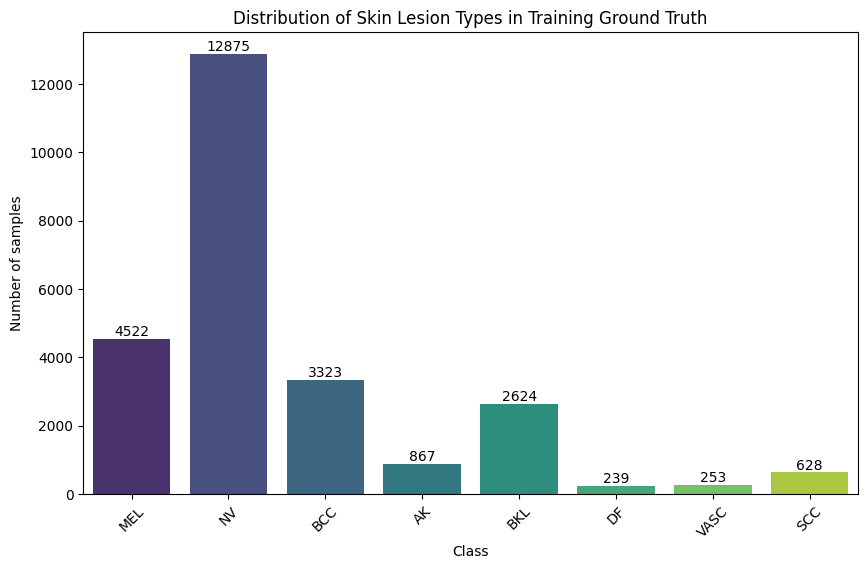

In [ ]:
import seaborn as sns

# Visualize distribution of data in the ground truth file
groundtruth_summary = train_lables.iloc[:, 1:].sum()   # (ignoring the first column that is header of column)
plt.figure(figsize=(10, 6))
sns.barplot(x=groundtruth_summary.index, y=groundtruth_summary.values, palette="viridis")

# Add total count labels above each bar
for i, count in enumerate(groundtruth_summary.values):
    plt.text(i, count + 10, f'{int(count)}', ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Skin Lesion Types in Training Ground Truth')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Define CONSTANT for LR, IP_SHAPE, Batch_SIZE, EPOCHS, CLASSES

INPUT_SHAPE = (32, 32, 3)  # Resize images to 32x32 pixels
NUM_CLASSES = len(train_lables.columns[1:])  # Number of skin cancer types 8
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

In [ ]:
from collections import Counter

# etract image IDs and labals from the training labels file

image_ids = train_lables['image']
labels = train_lables.iloc[:, 1:].values      #extract one hot encoded labels

# Convert one-hot encoding to class labels
y = np.argmax(labels, axis=1)  # Converts 2D one-hot array to 1D class labels

# Print class distribution
print(f"Class distribution before oversampling: {Counter(y)}")

Class distribution before oversampling: Counter({1: 12875, 0: 4522, 2: 3323, 4: 2624, 3: 867, 7: 628, 6: 253, 5: 239})


In [ ]:
# Load Training Images
X = []

for image_id in image_ids:
    image_path = os.path.join(train_image_path, f"{image_id}.jpg")
    img = load_img(image_path, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))  # Resize to match model input
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    X.append(img_array)


# Normalize images
X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int32)

X.shape, y.shape

((25331, 32, 32, 3), (25331,))

In [ ]:
# Maximum Value Count

max_samples = int(max(np.sum(labels, axis=0)))
max_samples

12875

In [ ]:
print("Shape of y:", y.shape)


# y is not one-hot encoded, reconvert it before oversampling
from sklearn.preprocessing import OneHotEncoder

# Check if y is 1D (class labels instead of one-hot)
if len(y.shape) == 1:
    y = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))

print("Shape of y after one-hot encoding:", y.shape)

Shape of y: (25331,)
Shape of y after one-hot encoding: (25331, 8)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

In [ ]:
# Print shapes of the arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

# Print sizes using len()
print("Number of samples in X_train:", len(X_train))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in X_val:", len(X_val))
print("Number of samples in y_val:", len(y_val))

Shape of X_train: (20264, 32, 32, 3)
Shape of y_train: (20264, 8, 8)
Shape of X_val: (5067, 32, 32, 3)
Shape of y_val: (5067, 8, 8)
Number of samples in X_train: 20264
Number of samples in y_train: 20264
Number of samples in X_val: 5067
Number of samples in y_val: 5067


In [ ]:
y_train = np.argmax(y_train, axis=-1)  # Converts (None, 8, 8) → (None, 8)
y_val = np.argmax(y_val, axis=-1)

print("New shape of y_train:", y_train.shape)
print("New shape of y_val:", y_val.shape)

New shape of y_train: (20264, 8)
New shape of y_val: (5067, 8)


In [ ]:
# Define Custom CNN Model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation="relu", padding="SAME", input_shape=INPUT_SHAPE))
model.add(Conv2D(32, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# Block 3
model.add(Conv2D(128, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Conv2D(256, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(256, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Display Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,481,992 (5.65 MB)

 Trainable params: 1,480,072 (5.65 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# compile our model

model.compile(
    optimizer=Adamax(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

In [ ]:
# Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor="val_acc", patience=10, mode="max", restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_lr=1e-6)

In [ ]:
# Training the model with updated configuration
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.3494 - auc: 0.6801 - loss: 2.0661 - precision: 0.4974 - recall: 0.1393 - val_accuracy: 0.1299 - val_auc: 0.5223 - val_loss: 2.3741 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
 24/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5426 - auc: 0.8455 - loss: 1.4268 - precision: 0.7209 - recall: 0.3707

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5498 - auc: 0.8579 - loss: 1.3725 - precision: 0.7207 - recall: 0.3803 - val_accuracy: 0.4681 - val_auc: 0.8447 - val_loss: 1.4763 - val_precision: 0.8592 - val_recall: 0.1083 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5657 - auc: 0.8889 - loss: 1.2323 - precision: 0.7347 - recall: 0.4206 - val_accuracy: 0.5715 - val_auc: 0.8857 - val_loss: 1.2661 - val_precision: 0.6649 - val_recall: 0.4616 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5890 - auc: 0.9024 - loss: 1.1590 - precision: 0.7332 - recall: 0.4519 - val_accuracy: 0.5634 - val_auc: 0.8978 - val_loss: 1.2441 - val_precision: 0.6312 - val_recall: 0.5005 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5956 - auc: 0.9074 - loss: 1.1291 - precision: 0.7463 - recall: 0.4517 - val_accuracy: 0.5463 - val_auc: 0.8789 - val_loss: 1.4319 - val_precisi

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score

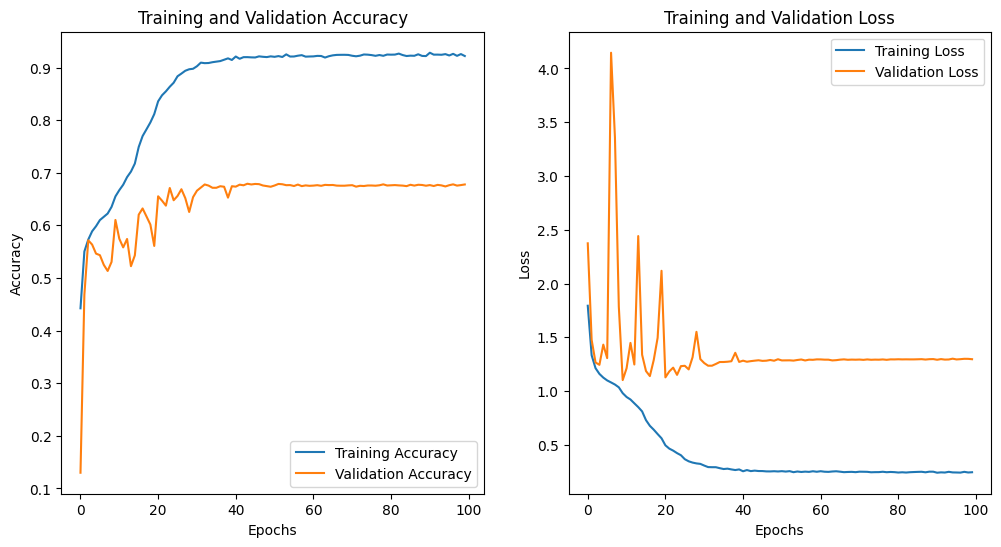

In [ ]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
def evaluate_model_and_confusion_matrix(model, X_val, y_val, label_mapping):
    """
    Evaluate the trained model on the validation set and display the confusion matrix, accuracy score, and balanced accuracy score.
    """
    print("Evaluating the model...")

    # Predict the validation set
    y_pred = model.predict(X_val)

    # Convert probabilities to class labels (assuming multi-class classification)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert actual labels from one-hot encoding to class indices
    y_true = np.argmax(y_val, axis=1)

    # Compute accuracy score
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy Score: {accuracy:.4f}")

    # Compute balanced accuracy score
    balanced_acc = balanced_accuracy_score(y_true, y_pred_classes)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping)))  # FIXED

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

Evaluating the model...
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy Score: 0.6771
Balanced Accuracy Score: 0.4325
Classification Report:
              precision    recall  f1-score   support

         MEL       0.58      0.54      0.56       915
          NV       0.80      0.86      0.83      2567
         BCC       0.63      0.61      0.62       658
          AK       0.27      0.20      0.23       177
         BKL       0.43      0.44      0.43       536
          DF       0.43      0.06      0.11        48
        VASC       0.78      0.50      0.61        62
         SCC       0.35      0.25      0.29       104

    accuracy                           0.68      5067
   macro avg       0.53      0.43      0.46      5067
weighted avg       0.66      0.68      0.67      5067



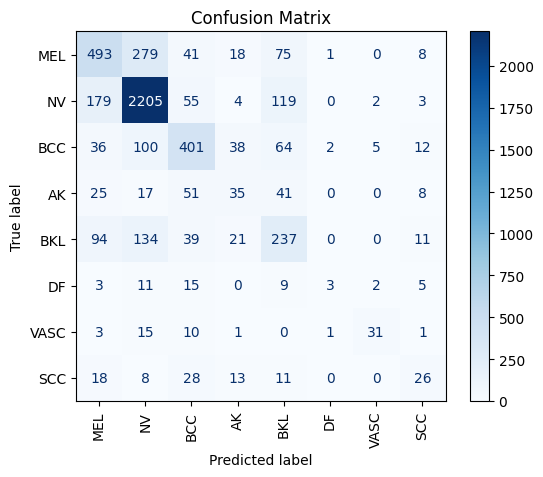

In [ ]:
evaluate_model_and_confusion_matrix(model, X_val, y_val, train_lables.columns[1:])

In [ ]:
model_path = '/content/drive/MyDrive/Dataset/Pre_Imabalance_ISIC2019_dcnn_model.h5'
model.save(model_path)
print(f"Model saved successfully at {model_path}.")

Model saved successfully at /content/drive/MyDrive/Dataset/Pre_Imabalance_ISIC2019_dcnn_model.h5.
